In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import TweetTokenizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import xgboost

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
file_path = 'HateXplain-Dataset.xlsx'
df = pd.read_excel(file_path)

print(df.columns)
df.head()

Index(['Unnamed: 0', 'origin_id', 'target', 'text', 'label'], dtype='object')


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
4,4,1179085312976445440,gender,this bitch in whataburger eating a burger with...,hs


In [ ]:
print(f"Dataset size (total number of elements): {df.size}")
print(f"Dataset shape (rows, columns): {df.shape}")

Dataset size (total number of elements): 79525
Dataset shape (rows, columns): (15905, 5)


In [ ]:
# Filter for rows where target is 'ethnicity'
ethnicity_df = df[df['target'] == 'ethnicity']

# Display the shape and first few rows of the filtered dataset
print(f"Ethnicity dataset shape: {ethnicity_df.shape}")
ethnicity_df.head()


Ethnicity dataset shape: (5801, 5)


,Unnamed: 0,origin_id,target,text,label
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
5,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
6,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
7,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Filter for rows where target is NaN
nan_target_df = df[df['target'].isnull()]

# Display the shape and first few rows of the filtered dataset
print(f"NaN target dataset shape: {nan_target_df.shape}")
nan_target_df.head()

NaN target dataset shape: (4850, 5)


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
11,11,1159278048069464065,NaN,<percent> cotton thigh highs to avoid contact ...,nhs
12,12,1170440965888335874,NaN,oomf a <number> yearl old closet gay and obses...,nhs
14,14,1122734457230774272,NaN,fellas be careful she texting other niggas,nhs


In [ ]:
# Filter for rows where target is NaN
nan_target_df = df[df['target'].isnull()]

# Display the shape and first few rows of the filtered dataset
print(f"NaN target dataset shape: {nan_target_df.shape}")
nan_target_df.head()

NaN target dataset shape: (4850, 5)


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
11,11,1159278048069464065,NaN,<percent> cotton thigh highs to avoid contact ...,nhs
12,12,1170440965888335874,NaN,oomf a <number> yearl old closet gay and obses...,nhs
14,14,1122734457230774272,NaN,fellas be careful she texting other niggas,nhs


In [ ]:
# Combine the two datasets (ethnicity and NaN target)
final_data = pd.concat([ethnicity_df, nan_target_df])

# Reset the index for the new DataFrame
final_data = final_data.reset_index(drop=True)

# Verify the 'target' column remains intact
print("Unique targets in the final dataset:")
print(final_data['target'].unique())

# Verify the 'label' column remains intact
print("Unique labels in the final dataset:")
print(final_data['label'].unique())

# Display the shape of the final dataset
print(f"Final dataset shape: {final_data.shape}")
final_data.head()

Unique targets in the final dataset:
['ethnicity' nan]
Unique labels in the final dataset:
['nhs' 'hs']
Final dataset shape: (10651, 5)


,Unnamed: 0,origin_id,target,text,label
0,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
1,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
3,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
4,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


**Data Preprocessing**




In [ ]:
#drop unwanted columns
final_data = final_data.drop(['Unnamed: 0', 'origin_id'], axis=1)
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Check for missing values in the dataset
print("Missing values per column:")
print(final_data.isnull().sum())


Missing values per column:
target    4850
text         0
label        0
dtype: int64


Since there's no missing values, we r not handling the missing values

In [ ]:
#Remove unnecessary characters, such as mentions (@user), URLs, and special characters,

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply cleaning to the 'text' column
final_data['text'] = final_data['text'].apply(clean_text)

# Display a few cleaned rows
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,user i am bit confused coz chinese ppl can not...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# integer label encoding

# Map 'hs' (hate speech, in this context xenophobic) to 1 and 'nhs' (non-hate speech, here non-xenophobic) to 0
final_data['label'] = final_data['label'].map({'hs': 1, 'nhs': 0})

# Verify the transformation
print(final_data['label'].value_counts())

label
0    5387
1    5264
Name: count, dtype: int64


In [ ]:
#Stopwords removal

# Define stop words set
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {"make", "anything", "user", "say", "right", "someone","number","go","something","know","want","everyone","even","your"}
stop_words.update(custom_stop_words)

# Remove stop words from the 'text' column
final_data['text'] = final_data['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Display a few rows to verify
final_data.head()


,target,text,label
0,ethnicity,nawt yall niggers ignoring,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1
2,ethnicity,laura loomer raped screaming disgusting kike l...,1
3,ethnicity,end nigger trainee doctors speak properly lack...,1
4,ethnicity,nogs jews dykes enriching,1


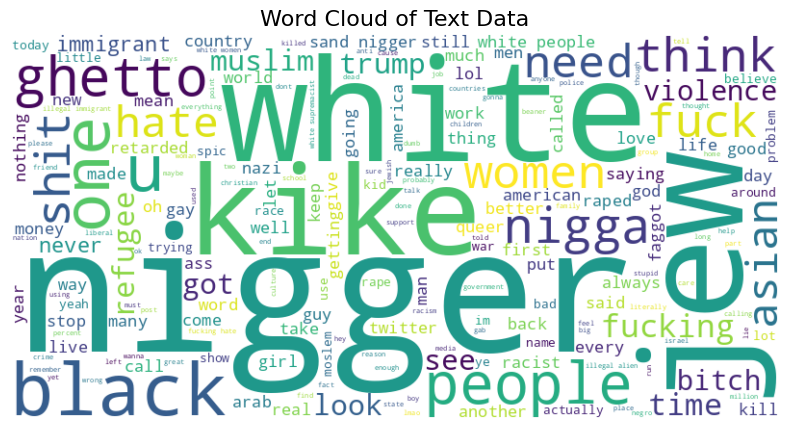

In [ ]:
#WordCloud

# Combine all text into one string
all_text = ' '.join(final_data['text'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Text Data", fontsize=16)
plt.show()


# **Approach II - Word Embeddings via GloVe**

Split dataset

In [ ]:
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1
2,ethnicity,laura loomer raped screaming disgusting kike l...,1
3,ethnicity,end nigger trainee doctors speak properly lack...,1
4,ethnicity,nogs jews dykes enriching,1


Lemmitazationn + POS Tagging via SpaCy

In [ ]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Lemmitazation + POS Tags
final_data['lemmatized_text'] = final_data['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
final_data.head()

,target,text,label,lemmatized_text,pos_tags
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (niggers, NOUN), (i..."
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (..."
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB..."
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ..."
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (..."


In [ ]:
# Split data (80% training, 20% testing). X is text while Y is label [0, 1]
trainx, testx, trainy, testy = train_test_split(final_data['lemmatized_text'], final_data['label'], test_size=0.2)

## Approach 1A: Without POS Tagging

Get the Word2Vec and GloVe models

In [ ]:
model = api.load('word2vec-google-news-300')

In [ ]:
glove_model = api.load('glove-twitter-100')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Word2Vec Function

In [ ]:
# Index2word is a list that contains the names of the words in
# the model's vocabulary. Convert it to a set, for speed
index2word_set = set(model.key_to_index)

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph

    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0.

    # Loop over each word and add its feature vector if in vocabulary
    for word in words:
        if word in index2word_set:
            nwords += 1.
            featureVec = np.add(featureVec, model[word])

    # Return the average if words were found; otherwise, return a zero vector
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

def avg_feature_vector(data, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(data), num_features),dtype="float32")
    #
    # Loop through the reviews
    for row in data:
       #
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print ("Review %d of %d" % (counter, len(data)))
       #
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[int(counter)] = makeFeatureVec(row, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1.
    return reviewFeatureVecs

print("X train model: \n")
trainx_w2vmodel = avg_feature_vector(trainx, model, 300)
print("-----------------")
print("X test model: \n")
testx_w2vmodel = avg_feature_vector(testx, model, 300)

X train model: 

Review 0 of 8520
Review 1000 of 8520
Review 2000 of 8520
Review 3000 of 8520
Review 4000 of 8520
Review 5000 of 8520
Review 6000 of 8520
Review 7000 of 8520
Review 8000 of 8520
-----------------
X test model: 

Review 0 of 2131
Review 1000 of 2131
Review 2000 of 2131


GloVe Function

In [ ]:
index2word_set = set(glove_model.key_to_index)

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0.

    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords += 1.
            featureVec = np.add(featureVec, model[word])

    # Only divide if nwords > 0 to avoid division by zero
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

def avg_feature_glove_vector(data, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(data), num_features),dtype="float32")
    #
    # Loop through the reviews
    for row in data:
       #
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print ("Review %d of %d" % (counter, len(data)))
       #
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[int(counter)] = makeFeatureVec(row, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1.
    return reviewFeatureVecs

print("X train model: \n")
trainx_glove_model = avg_feature_glove_vector(trainx, glove_model, 100)
print("-----------------")
print("X test model: \n")
testx_glove_model = avg_feature_glove_vector(testx, glove_model, 100)

X train model: 

Review 0 of 8520
Review 1000 of 8520
Review 2000 of 8520
Review 3000 of 8520
Review 4000 of 8520
Review 5000 of 8520
Review 6000 of 8520
Review 7000 of 8520
Review 8000 of 8520
-----------------
X test model: 

Review 0 of 2131
Review 1000 of 2131
Review 2000 of 2131


# Set Up the Training Models

1. SVC

In [ ]:
# Training the model using the Support Vector Classification class of sklearn
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1, random_state=42, class_weight='balanced')

In [ ]:
# SVM run
svc.fit(trainx_glove_model, trainy)
predy = svc.predict(testx_glove_model)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6420
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.78      0.69      1074
           1       0.69      0.50      0.58      1057

    accuracy                           0.64      2131
   macro avg       0.65      0.64      0.63      2131
weighted avg       0.65      0.64      0.63      2131



In [ ]:
# 2nd SVM run
svc.fit(trainx_w2vmodel, trainy)
predy = svc.predict(testx_w2vmodel)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6668
Classification Report
               precision    recall  f1-score   support

           0       0.66      0.70      0.68      1074
           1       0.67      0.63      0.65      1057

    accuracy                           0.67      2131
   macro avg       0.67      0.67      0.67      2131
weighted avg       0.67      0.67      0.67      2131



2. XGBoost

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, objective='binary:logistic', eval_metric='logloss', max_depth=6, n_estimators=100, subsample=0.8, colsample_bytree=0.8)

In [ ]:
# Convert Pandas DataFrames to NumPy arrays
trainxgb = np.array(trainx_glove_model)
testxgb = np.array(testx_glove_model)

# Train xgb model
xgb.fit(trainxgb, trainy)
predy = xgb.predict(testxgb)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6551
Classification Report
               precision    recall  f1-score   support

           0       0.65      0.68      0.66      1074
           1       0.66      0.63      0.65      1057

    accuracy                           0.66      2131
   macro avg       0.66      0.65      0.65      2131
weighted avg       0.66      0.66      0.65      2131



In [ ]:
# Convert Pandas DataFrames to NumPy arrays
trainxgb = np.array(trainx_w2vmodel)
testxgb = np.array(testx_w2vmodel)

# Train xgb model
xgb.fit(trainxgb, trainy)
predy = xgb.predict(testxgb)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6762
Classification Report
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1074
           1       0.67      0.67      0.67      1057

    accuracy                           0.68      2131
   macro avg       0.68      0.68      0.68      2131
weighted avg       0.68      0.68      0.68      2131



3. Logistic Regression

In [ ]:
logreg = LogisticRegression(C=1.0, solver='lbfgs', max_iter=200, class_weight='balanced')

logreg.fit(trainx_w2vmodel, trainy)

predy_cont = logreg.predict(testx_w2vmodel)
predy = (predy_cont > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6481
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.69      0.66      1074
           1       0.66      0.61      0.63      1057

    accuracy                           0.65      2131
   macro avg       0.65      0.65      0.65      2131
weighted avg       0.65      0.65      0.65      2131



In [ ]:
logreg.fit(trainx_glove_model, trainy)
predy = logreg.predict(testx_glove_model)

predy_cont = logreg.predict(testx_glove_model)
predy = (predy_cont > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.6527
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.70      0.67      1074
           1       0.67      0.60      0.63      1057

    accuracy                           0.65      2131
   macro avg       0.65      0.65      0.65      2131
weighted avg       0.65      0.65      0.65      2131



# Approach 1B: With POS Tagging

With POS tagging, the context is obtained, therefore, a higher accuracy is anticipated.

In [ ]:
final_data['pos_tags'] = final_data['text'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x) if not token.is_stop])
final_data.head()

,target,text,label,lemmatized_text,pos_tags
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (niggers, NOUN), (i..."
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (..."
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB..."
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ..."
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (..."


In [ ]:
# Split data (80% training, 20% testing). X is text while Y is label [0, 1]
trainx, testx, trainy, testy = train_test_split(final_data[['lemmatized_text', 'pos_tags']], final_data['label'], test_size=0.2)

In [ ]:
# Adjust POS tag weights based on the task domain
weight_dict = {
    "NN": 1.0,  # Noun: Important for topic classification but less so for sentiment
    "VB": 1.2,  # Verb: Important in sentiment analysis as they express actions/emotions
    "JJ": 1.5,  # Adjective: Extremely important for sentiment-related tasks
    "RB": 1.0,  # Adverb: Also important for sentiment, but usually less so than adjectives
    "PR": 0.8,  # Pronoun: Usually neutral but can be important in context
    "DT": 0.7,  # Determiner: Important for syntactic structure but less for semantics
    "IN": 0.8,  # Preposition: Important in some contexts but less critical
    # Default weight for unknown or irrelevant POS tags
}

def get_pos_weight(pos_tag):
    return weight_dict.get(pos_tag[:2], 0.8)  # Default weight is 0.8


Modified GloVe Function

In [ ]:
def makeFeatureVec(words, pos_tags, model, num_features, use_pos_tags):
    """
    Function to create a feature vector by averaging the word vectors of words in a given review.
    Optionally, it integrates POS tag weighting.

    :param words: List of words in the review.
    :param pos_tags: List of corresponding POS tags for the words.
    :param model: GloVe model.
    :param num_features: Number of features in the embedding (i.e., the vector size).
    :param use_pos_tags: Whether to apply POS tag weighting.

    :return: Averaged word vector for the review.
    """
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0.0

    # Loop over each word and its corresponding POS tag
    for word, pos_tag in zip(words, pos_tags):
        if word in model.key_to_index:  # Only consider words in the model's vocabulary
            word_vec = model[word]
            pos_weight = get_pos_weight(pos_tag) if use_pos_tags else 1.0  # Apply POS tag weighting if enabled
            featureVec = np.add(featureVec, word_vec * pos_weight)
            nwords += 1.0

    # Return the average vector if there are words, otherwise return a zero vector
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

def avg_feature_vector(data, pos_tags_data, model, num_features, use_pos_tags):
    """
    Given a list of reviews and their POS tags, calculate the average feature vector for each review.

    :param data: List of tokenized reviews (list of words).
    :param pos_tags_data: List of POS tag sequences corresponding to the reviews.
    :param model: GloVe model.
    :param num_features: Number of features in the embedding.
    :param use_pos_tags: Whether to apply POS tag weighting.

    :return: A 2D numpy array with average feature vectors for each review.
    """
    counter = 0
    reviewFeatureVecs = np.zeros((len(data), num_features), dtype="float32")

    # Loop through the data and POS tags
    for row, pos_tags in zip(data, pos_tags_data):
        # Print progress every 1000th review
        if counter % 1000 == 0:
            print(f"Processing review {int(counter)} of {len(data)}...")

        # Process each review and its POS tags
        reviewFeatureVecs[counter] = makeFeatureVec(row.split(), pos_tags, model, num_features, use_pos_tags)
        counter += 1

    return reviewFeatureVecs


# Assuming the GloVe model has been loaded
print("Processing training data with GloVe and POS tags...")
trainx_glove_model = avg_feature_vector(trainx['lemmatized_text'], trainx['pos_tags'], glove_model, 100, use_pos_tags=True)

print("Processing test data with GloVe and POS tags...")
testx_glove_model = avg_feature_vector(testx['lemmatized_text'], testx['pos_tags'], glove_model, 100, use_pos_tags=True)


Processing training data with GloVe and POS tags...
Processing review 0 of 8520...
Processing review 1000 of 8520...
Processing review 2000 of 8520...
Processing review 3000 of 8520...
Processing review 4000 of 8520...
Processing review 5000 of 8520...
Processing review 6000 of 8520...
Processing review 7000 of 8520...
Processing review 8000 of 8520...
Processing test data with GloVe and POS tags...
Processing review 0 of 2131...
Processing review 1000 of 2131...
Processing review 2000 of 2131...


Modified Word2Vec Function

In [ ]:
def makeFeatureVec_with_pos(words, pos_tags, model, num_features):
    """
    Compute the weighted feature vector for a sentence using words and their POS tags.
    """
    # Initialize featureVec with the correct dimensionality (e.g., 300 for Word2Vec)
    featureVec = np.zeros((model.vector_size,), dtype="float32")  # Use model.vector_size to dynamically fetch embedding size
    nwords = 0

    # Iterate through words and corresponding POS tags
    for word, pos in zip(words, pos_tags):
        if word in model:
            nwords += 1
            pos_weight = get_pos_weight(pos)  # Retrieve the weight for the POS tag
            featureVec = np.add(featureVec, model[word] * pos_weight)

    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)  # Normalize by the number of words

    return featureVec


def avg_feature_vector_with_pos(data, model, num_features):
    """
    Compute average feature vectors for all sentences in the dataset,
    integrating POS tags with Word2Vec embeddings.
    """
    num_samples = len(data)
    reviewFeatureVecs = np.zeros((num_samples, num_features), dtype="float32")

    for idx, row in enumerate(data.itertuples()):
        words = row.lemmatized_text.split()
        pos_tags = [tag for _, tag in row.pos_tags]
        reviewFeatureVecs[idx] = makeFeatureVec_with_pos(words, pos_tags, model, num_features)

    return reviewFeatureVecs


# Assuming the model has been loaded already
print("Processing training data with Word2Vec and POS tags...")
trainx_w2vmodel = avg_feature_vector_with_pos(trainx, model, model.vector_size)  # Use word2vec_model.vector_size to get the correct size

print("Processing test data with Word2Vec and POS tags...")
testx_w2vmodel = avg_feature_vector_with_pos(testx, model, model.vector_size)  # Use word2vec_model.vector_size to get the correct size


Processing training data with Word2Vec and POS tags...
Processing test data with Word2Vec and POS tags...


# Set Up the Training Models (again)

In [ ]:
# Training the model using the Support Vector Classification class of sklearn
svc = SVC(kernel='rbf', C=1, random_state=42, class_weight='balanced')

In [ ]:
# SVM run
svc.fit(trainx_glove_model, trainy)
predy = svc.predict(testx_glove_model)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.7658
Classification Report
               precision    recall  f1-score   support

           0       0.76      0.79      0.77      1079
           1       0.77      0.74      0.76      1052

    accuracy                           0.77      2131
   macro avg       0.77      0.77      0.77      2131
weighted avg       0.77      0.77      0.77      2131



In [ ]:
# 2nd SVM run
svc.fit(trainx_w2vmodel, trainy)
predy = svc.predict(testx_w2vmodel)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.8024
Classification Report
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      1079
           1       0.83      0.75      0.79      1052

    accuracy                           0.80      2131
   macro avg       0.81      0.80      0.80      2131
weighted avg       0.80      0.80      0.80      2131



2. XGBoost

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, objective='binary:logistic', eval_metric='logloss', max_depth=6, n_estimators=100, subsample=0.8, colsample_bytree=0.8)

In [ ]:
# Convert Pandas DataFrames to NumPy arrays
trainxgb = np.array(trainx_glove_model)
testxgb = np.array(testx_glove_model)

# Train xgb model
xgb.fit(trainxgb, trainy)
predy = xgb.predict(testxgb)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.7555
Classification Report
               precision    recall  f1-score   support

           0       0.74      0.79      0.77      1079
           1       0.77      0.72      0.74      1052

    accuracy                           0.76      2131
   macro avg       0.76      0.76      0.76      2131
weighted avg       0.76      0.76      0.76      2131



In [ ]:
# Convert Pandas DataFrames to NumPy arrays
trainxgb = np.array(trainx_w2vmodel)
testxgb = np.array(testx_w2vmodel)

# Train xgb model
xgb.fit(trainxgb, trainy)
predy = xgb.predict(testxgb)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.7738
Classification Report
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      1079
           1       0.79      0.74      0.76      1052

    accuracy                           0.77      2131
   macro avg       0.77      0.77      0.77      2131
weighted avg       0.77      0.77      0.77      2131



3. Logistic Regression

In [ ]:
logreg = LogisticRegression(C=1.0, solver='lbfgs', max_iter=200, class_weight='balanced')

logreg.fit(trainx_w2vmodel, trainy)

predy_cont = logreg.predict(testx_w2vmodel)
predy = (predy_cont > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.7682
Classification Report
               precision    recall  f1-score   support

           0       0.75      0.82      0.78      1079
           1       0.80      0.71      0.75      1052

    accuracy                           0.77      2131
   macro avg       0.77      0.77      0.77      2131
weighted avg       0.77      0.77      0.77      2131



In [ ]:
logreg.fit(trainx_glove_model, trainy)
predy = logreg.predict(testx_glove_model)

predy_cont = logreg.predict(testx_glove_model)
predy = (predy_cont > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(testy, predy)
report = classification_report(testy, predy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report\n {report}")

Accuracy: 0.7203
Classification Report
               precision    recall  f1-score   support

           0       0.71      0.76      0.73      1079
           1       0.74      0.68      0.70      1052

    accuracy                           0.72      2131
   macro avg       0.72      0.72      0.72      2131
weighted avg       0.72      0.72      0.72      2131

